In [1]:
import seaborn as sns
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()


,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [2]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [3]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [4]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [5]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [6]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [7]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [8]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


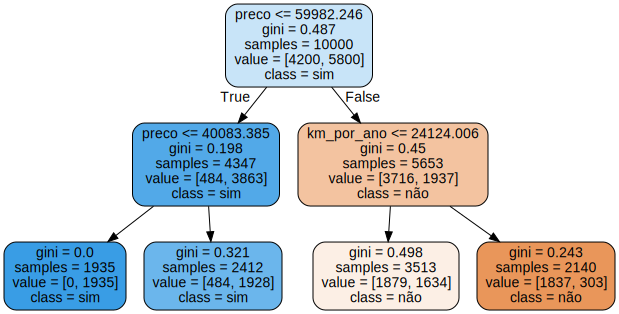

In [9]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

In [10]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


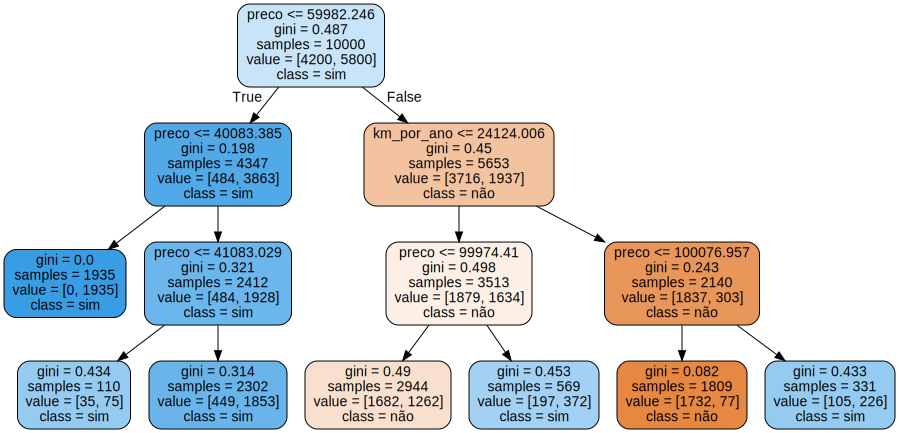

In [11]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

In [12]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 77.19
Intervalo [75.26, 79.13]


# Explorando hiper parâmetros em uma dimensão


In [13]:
def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Arvore max_depth = %d, treino = %.2f, teste = %.2f" % (max_depth, train_score, test_score))
  tabela = [max_depth, train_score, test_score]
  return tabela
  
resultados = [roda_arvore_de_decisao(i) for i in range(1,33)]
resultados = pd.DataFrame(resultados, columns= ["max_depth","train","test"])
resultados.head()


Arvore max_depth = 1, treino = 75.79, teste = 75.78
Arvore max_depth = 2, treino = 75.79, teste = 75.78
Arvore max_depth = 3, treino = 78.75, teste = 78.67
Arvore max_depth = 4, treino = 78.79, teste = 78.63
Arvore max_depth = 5, treino = 78.94, teste = 78.56
Arvore max_depth = 6, treino = 79.17, teste = 78.12
Arvore max_depth = 7, treino = 79.50, teste = 77.96
Arvore max_depth = 8, treino = 79.89, teste = 77.86
Arvore max_depth = 9, treino = 80.46, teste = 77.38
Arvore max_depth = 10, treino = 81.16, teste = 77.19
Arvore max_depth = 11, treino = 82.03, teste = 76.97
Arvore max_depth = 12, treino = 82.89, teste = 76.49
Arvore max_depth = 13, treino = 83.95, teste = 75.81
Arvore max_depth = 14, treino = 85.03, teste = 75.66
Arvore max_depth = 15, treino = 86.14, teste = 75.16
Arvore max_depth = 16, treino = 87.19, teste = 75.11
Arvore max_depth = 17, treino = 88.31, teste = 74.74
Arvore max_depth = 18, treino = 89.26, teste = 74.33
Arvore max_depth = 19, treino = 90.32, teste = 74.34
Ar

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


<AxesSubplot:xlabel='max_depth', ylabel='train'>

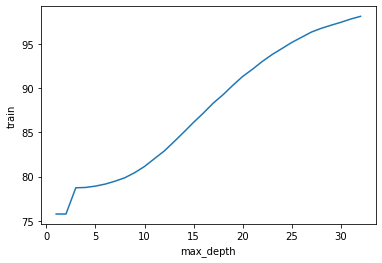

In [14]:
import seaborn as sns

sns.lineplot(x = "max_depth", y = "train", data = resultados)

# OVERFIT: ficou "perfeito" para o treino mas ruim para o teste

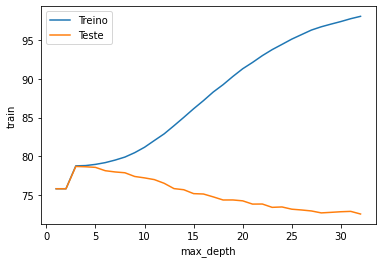

In [15]:
import matplotlib.pyplot as plt

sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)
plt.legend(["Treino", "Teste"])

In [16]:
resultados.sort_values("test", ascending=False).head()


,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


# Explorando hiper parâmetros em 2 dimensões

In [17]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Arvore max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, train_score, test_score))
  tabela = [max_depth, min_samples_leaf, train_score, test_score]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
  return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 64, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Arvore max_depth = 4, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 

Arvore max_depth = 28, min_samples_leaf = 32, treino = 80.89, teste = 76.84
Arvore max_depth = 28, min_samples_leaf = 64, treino = 79.79, teste = 77.30
Arvore max_depth = 28, min_samples_leaf = 128, treino = 79.21, teste = 78.22
Arvore max_depth = 28, min_samples_leaf = 256, treino = 78.90, teste = 77.85
Arvore max_depth = 29, min_samples_leaf = 32, treino = 80.89, teste = 76.84
Arvore max_depth = 29, min_samples_leaf = 64, treino = 79.79, teste = 77.30
Arvore max_depth = 29, min_samples_leaf = 128, treino = 79.21, teste = 78.22
Arvore max_depth = 29, min_samples_leaf = 256, treino = 78.90, teste = 77.85
Arvore max_depth = 30, min_samples_leaf = 32, treino = 80.89, teste = 76.84
Arvore max_depth = 30, min_samples_leaf = 64, treino = 79.79, teste = 77.30
Arvore max_depth = 30, min_samples_leaf = 128, treino = 79.21, teste = 78.22
Arvore max_depth = 30, min_samples_leaf = 256, treino = 78.90, teste = 77.85
Arvore max_depth = 31, min_samples_leaf = 32, treino = 80.89, teste = 76.84
Arvore

,max_depth,min_samples_leaf,train,test
0,1,32,75.791169,75.784219
1,1,64,75.791169,75.784219
2,1,128,75.791169,75.784219
3,1,256,75.791169,75.784219
4,2,32,75.791169,75.784219


In [18]:
resultados.sort_values("test", ascending=False).head()


,max_depth,min_samples_leaf,train,test
15,4,256,78.750993,78.672633
12,4,32,78.750993,78.672633
14,4,128,78.750993,78.672633
13,4,64,78.750993,78.672633
8,3,32,78.750993,78.672633


In [19]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,-2.780775e-16,0.536705,-0.027675
min_samples_leaf,-2.780775e-16,1.000000e+00,-0.409676,0.349011
train,5.367048e-01,-4.096762e-01,1.000000,0.116466
test,-2.767507e-02,3.490111e-01,0.116466,1.000000


<AxesSubplot:>

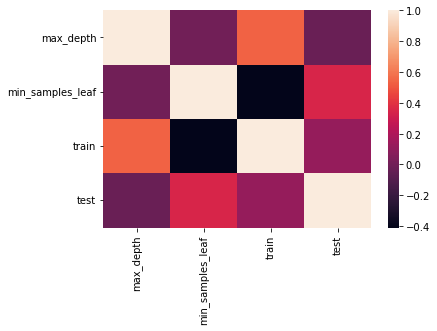

In [20]:
sns.heatmap(corr)

AttributeError: module 'pandas' has no attribute 'scatter_matrix'

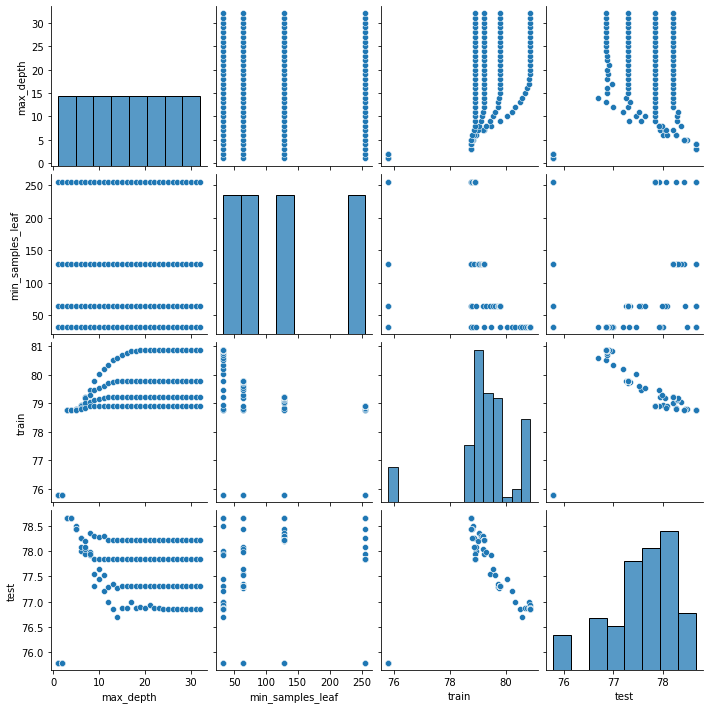

In [22]:
sns.pairplot(resultados)


C:\Users\mathe\AppData\Local\Temp\ipykernel_1164\1569857682.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

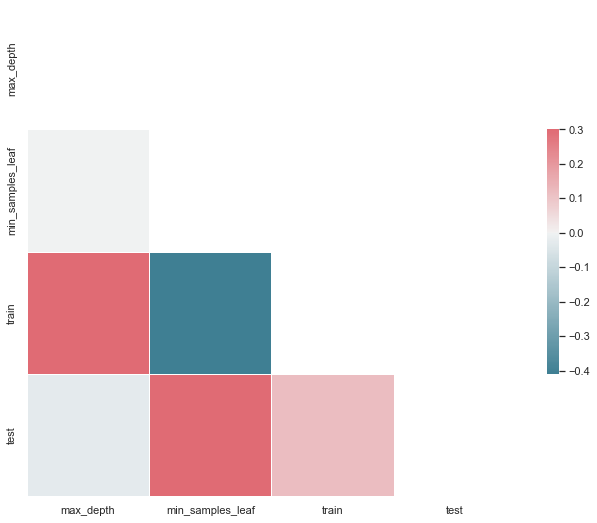

In [23]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [24]:
def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [128, 192, 256, 512]:
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
  return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 192, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 512, treino = 77.53, teste = 77.50
Arvore max_depth = 4, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_d

Arvore max_depth = 27, min_samples_leaf = 512, treino = 77.53, teste = 77.50
Arvore max_depth = 28, min_samples_leaf = 128, treino = 79.21, teste = 78.22
Arvore max_depth = 28, min_samples_leaf = 192, treino = 79.01, teste = 78.05
Arvore max_depth = 28, min_samples_leaf = 256, treino = 78.90, teste = 77.85
Arvore max_depth = 28, min_samples_leaf = 512, treino = 77.53, teste = 77.50
Arvore max_depth = 29, min_samples_leaf = 128, treino = 79.21, teste = 78.22
Arvore max_depth = 29, min_samples_leaf = 192, treino = 79.01, teste = 78.05
Arvore max_depth = 29, min_samples_leaf = 256, treino = 78.90, teste = 77.85
Arvore max_depth = 29, min_samples_leaf = 512, treino = 77.53, teste = 77.50
Arvore max_depth = 30, min_samples_leaf = 128, treino = 79.21, teste = 78.22
Arvore max_depth = 30, min_samples_leaf = 192, treino = 79.01, teste = 78.05
Arvore max_depth = 30, min_samples_leaf = 256, treino = 78.90, teste = 77.85
Arvore max_depth = 30, min_samples_leaf = 512, treino = 77.53, teste = 77.50

,max_depth,min_samples_leaf,train,test
0,1,128,75.791169,75.784219
1,1,192,75.791169,75.784219
2,1,256,75.791169,75.784219
3,1,512,75.791169,75.784219
4,2,128,75.791169,75.784219


In [25]:
corr = resultados.corr()

C:\Users\mathe\AppData\Local\Temp\ipykernel_1164\1569857682.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

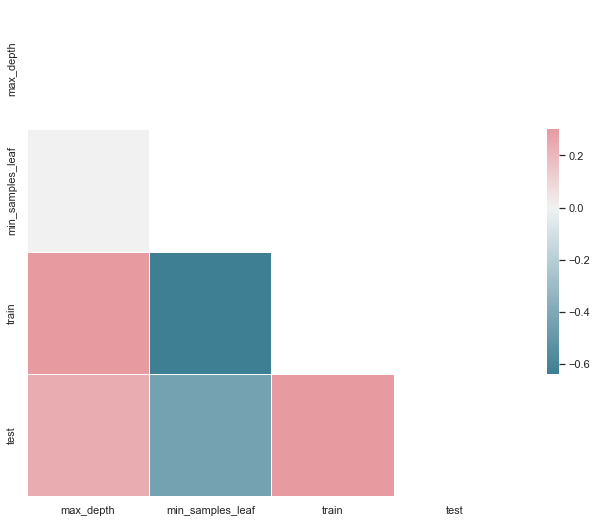

In [26]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [27]:
resultados.sort_values("test", ascending=False).head()


,max_depth,min_samples_leaf,train,test
13,4,192,78.750993,78.672633
8,3,128,78.750993,78.672633
9,3,192,78.750993,78.672633
10,3,256,78.750993,78.672633
14,4,256,78.750993,78.672633


# Explorando 3 dimensões de hiper parâmetros

In [28]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  fit_time = results['fit_time'].mean()
  score_time = results['score_time'].mean()
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
      for min_samples_split in [32, 64, 128, 256]:
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","min_samples_split","train","test", "fit_time", "score_time"])
  return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791169,75.784219,0.004590,0.001196
1,1,32,64,75.791169,75.784219,0.007577,0.001895
2,1,32,128,75.791169,75.784219,0.004084,0.001101
3,1,32,256,75.791169,75.784219,0.003978,0.001303
4,1,64,32,75.791169,75.784219,0.004086,0.001005


In [29]:
corr = resultados.corr()


C:\Users\mathe\AppData\Local\Temp\ipykernel_1164\1569857682.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

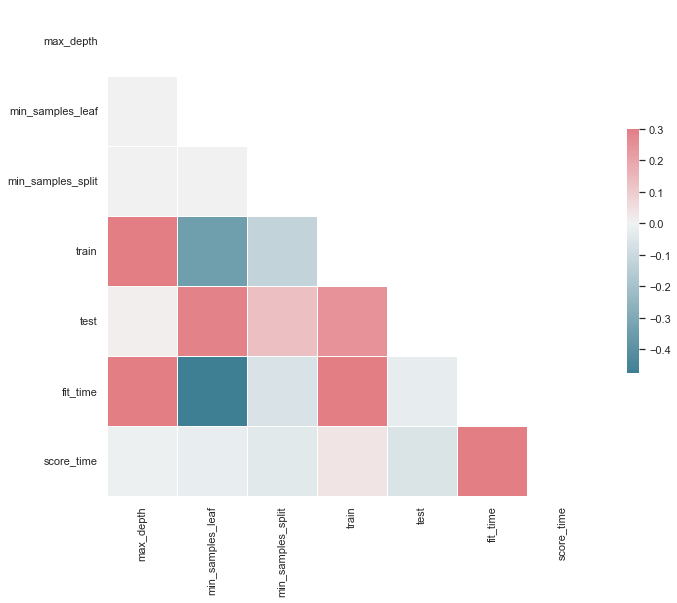

In [30]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [31]:
resultados.sort_values("test", ascending=False).head()


,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
63,4,256,256,78.750993,78.672633,0.009076,0.001202
48,4,32,32,78.750993,78.672633,0.011369,0.001991
34,3,32,128,78.750993,78.672633,0.008347,0.001399
35,3,32,256,78.750993,78.672633,0.010775,0.002194
36,3,64,32,78.750993,78.672633,0.007685,0.001194


# Explorando espaço de hiper parâmetros com GridSearchCV


In [32]:
from sklearn.model_selection import GridSearchCV

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits = 10))
busca.fit(x_azar, y_azar, groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()print(busca.best_params_)
print(busca.best_score_ * 100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007679,0.000900,0.001201,0.000401,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.008080,0.000536,0.001392,0.000486,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.008180,0.000598,0.001495,0.000498,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.008576,0.000487,0.001597,0.000490,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.012266,0.002526,0.002694,0.000641,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [33]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [34]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [35]:

from sklearn.metrics import accuracy_score

# evitar essa abordagem pois estará sendo otimista

predicoes = melhor.predict(x_azar)
accuracy = accuracy_score(predicoes, y_azar) * 100
print("Accuracy para os dados foi %.2f%%" % accuracy)

Accuracy para os dados foi 78.75%


# Como ter uma estimativa sem esse vício nos dados que eu já vi?


## No caso de cross validation com busca de hiper parâmetros, fazemos uma nova validação cruzada. Chama-se nested cross validation

In [36]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=10), groups = dados.modelo)

C:\Users\mathe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mathe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mathe\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 891, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\mathe\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1392, in _run_search
    evaluate_candidates(ParameterGrid(self.param_

# Infelizmente como o Pandas não suporta nested validation com group k fold não conseguimos prever o resultado para novos grupos

In [37]:
from sklearn.model_selection import GridSearchCV, KFold

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012167,0.003700,0.002793,0.001715,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.008379,0.000798,0.002193,0.000747,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.007580,0.000797,0.001795,0.000977,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.007775,0.001155,0.002003,0.000010,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.008171,0.001596,0.001799,0.000403,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [38]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

In [39]:
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [40]:

imprime_score(scores)

Accuracy médio 78.67
Intervalo [76.80, 80.54]


In [41]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)


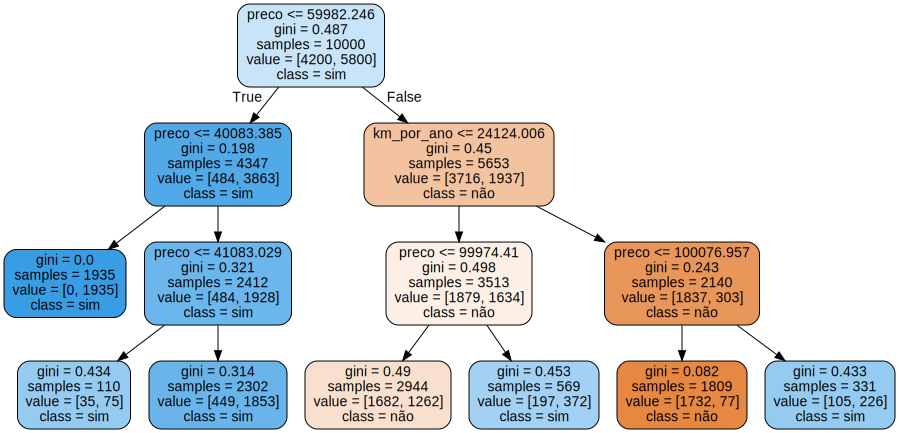

In [42]:
from sklearn.tree import export_graphviz
import graphviz

features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

# Busca aleatória com RandomSearch

In [43]:
from sklearn.model_selection import RandomizedSearchCV

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros, 
                    n_iter = 16,
                    cv = KFold(n_splits = 5),
                          random_state = SEED)


busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011377,0.001622,0.001793,0.000398,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.4330,0.4525,0.771,0.742,0.7725,0.6342,0.156817,1
1,0.007971,0.000887,0.001797,0.000399,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.4015,0.4165,0.771,0.766,0.7725,0.6255,0.176848,11
2,0.012961,0.005279,0.003796,0.003642,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.4015,0.4165,0.771,0.766,0.7725,0.6255,0.176848,11
3,0.015061,0.001556,0.001795,0.000747,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.4240,0.4535,0.771,0.750,0.7445,0.6286,0.155544,5
4,0.014960,0.000892,0.001995,0.000631,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.4240,0.4535,0.771,0.750,0.7445,0.6286,0.155544,5


In [46]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)

Accuracy médio 78.23
Intervalo [77.11, 79.35]


In [48]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=5, min_samples_leaf=128, min_samples_split=128)

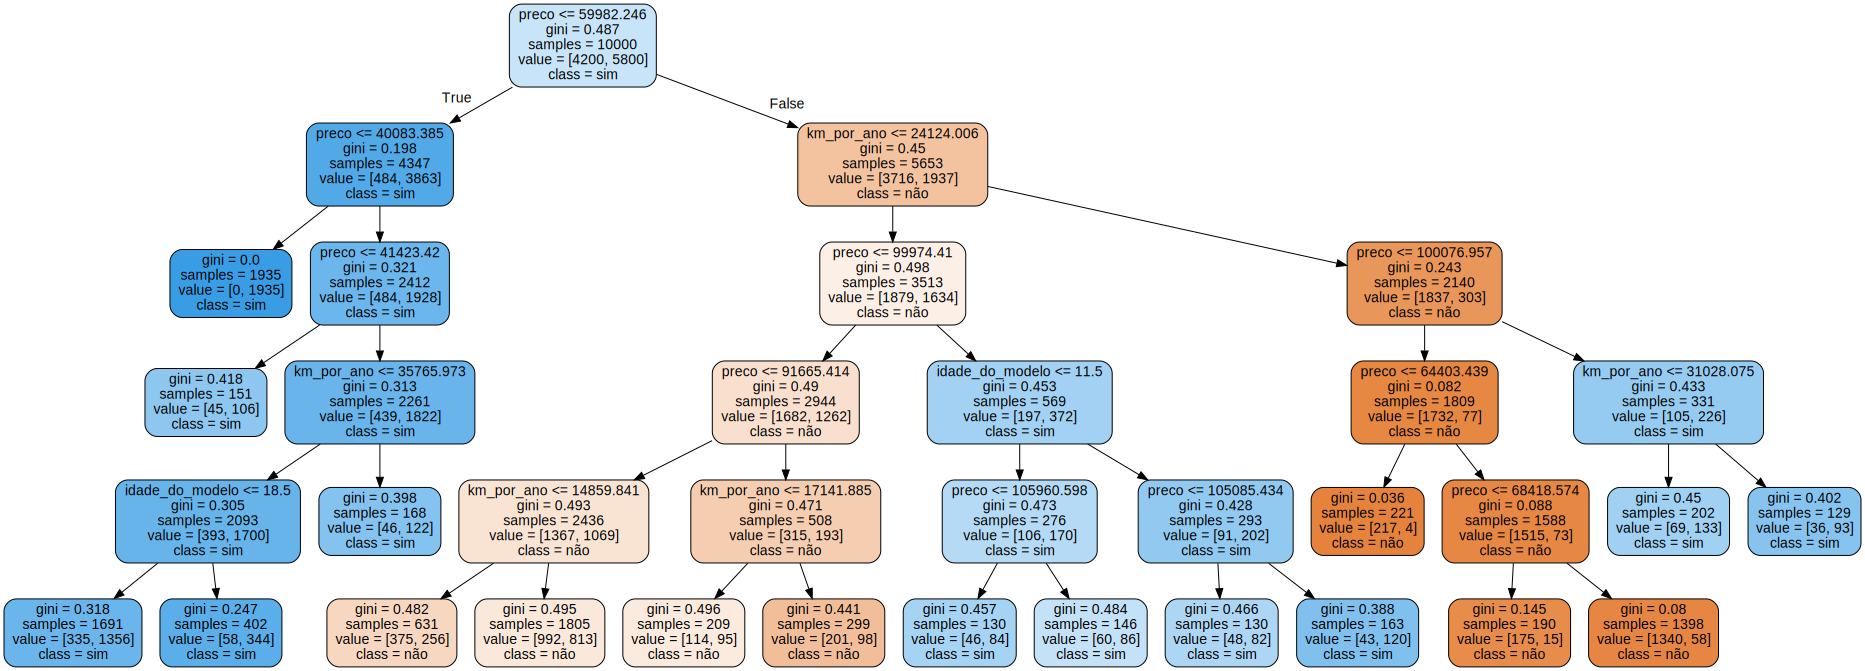

In [49]:
features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                        class_names=["não", "sim"],
                        feature_names = features)

graph = graphviz.Source(dot_data)
graph